<a href="https://colab.research.google.com/github/dt-cs/CMPSC-497-MID-TERM-PROJECT/blob/main/CMPSC_497_MID_TERM_PROJECT_TEXT_CLASSIFICATION_USING_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports

A CNN Model that takes the user queries and classifies the category of command in Rhino 3D.

In [ ]:
!pip install nltk

Import neccesary libraries

In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random
from tqdm import tqdm
import gensim.downloader as api
import matplotlib.pyplot as plt

Download NLTK to split the sentences into words

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Set random seeds for reproducibility
# this step is optional
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
#getting the train and test path to load the train and test data
train_path = "/content/train.json"
test_path = "/content/test.json"

In [ ]:
# Load data
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

print("Loading data...")
train_data = load_jsonl(train_path)
test_data = load_jsonl(test_path)

Loading data...


In [71]:
# Load GloVe embeddings using gensim
glove_vectors = load_glove_embeddings_gensim()
embedding_dim = glove_vectors.vector_size  # Should be 100 for 'glove-wiki-gigaword-100'

Loaded 400000 word vectors with dimension 100


In [ ]:
# Load GloVe embeddings using gensim
def load_glove_embeddings_gensim():
    print("Downloading and loading GloVe embeddings via gensim...")
    # Here we are using 100-d glove vectors
    glove_model = api.load("glove-wiki-gigaword-100")
    print(f"Loaded {len(glove_model.key_to_index)} word vectors with dimension {glove_model.vector_size}")
    return glove_model

In [72]:
# Initialize empty lists for queries and categories
train_queries = []
train_categories = []
test_queries = []
test_categories = []

# Extract queries and categories from training data
for item in train_data:
    query = item['query']
    category = item['category']
    train_queries.append(query)
    train_categories.append(category)

# Extract queries and categories from test data
for item in test_data:
    query = item['query']
    category = item['category']
    test_queries.append(query)
    test_categories.append(category)

In [ ]:
# Get unique categories
combined_categories = []
for cat in train_categories:
    combined_categories.append(cat)
for cat in test_categories:
    combined_categories.append(cat)

unique_categories = list(set(combined_categories))
unique_categories.sort()

# Create category to index mapping
category_to_idx = {}
for idx, cat in enumerate(unique_categories):
    category_to_idx[cat] = idx

# Create index to category mapping
idx_to_category = {}
for cat, idx in category_to_idx.items():
    idx_to_category[idx] = cat

print(f"Total unique categories: {len(unique_categories)}")

Total unique categories: 26


In [ ]:
# Convert categories to indices
train_labels = []
for cat in train_categories:
    train_labels.append(category_to_idx[cat])

test_labels = []
for cat in test_categories:
    test_labels.append(category_to_idx[cat])

print(f"Train labels: {train_labels[:5]}")
print(f"Test labels: {test_labels[:5]}")

Train labels: [9, 2, 15, 24, 3]
Test labels: [2, 24, 20, 25, 5]


In [ ]:
# Text preprocessing
def preprocess_text(text):
    # Convert to lowercase and remove non-alphanumeric characters
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    return tokens

In [ ]:
# Tokenize all queries
print("Preprocessing queries...")

train_tokens = []
for query in train_queries:
    tokens = preprocess_text(query)
    train_tokens.append(tokens)

test_tokens = []
for query in test_queries:
    tokens = preprocess_text(query)
    test_tokens.append(tokens)

# Build vocabulary from training data
vocab = set()
for tokens in train_tokens:
    vocab.update(tokens)

# Add special tokens
vocab.add("<PAD>")  # Padding token
vocab.add("<UNK>")  # Unknown token

# Create word to index mapping
# this is for debugging purposes not needed for training
word_to_idx = {word: idx for idx, word in enumerate(sorted(vocab))}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)

print(f"Vocabulary size: {vocab_size}")


Preprocessing queries...
Vocabulary size: 2608


In [ ]:
# Maximum sequence length for padding
max_length = max(len(tokens) for tokens in train_tokens + test_tokens)
max_length = min(max_length, 50)  # Cap at 50 tokens for efficiency
print(f"Maximum sequence length: {max_length}")


Maximum sequence length: 23


In [ ]:
# Create embedding matrix with GloVe vectors from gensim
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word_to_idx.items():
    if word in glove_vectors:
        embedding_matrix[idx] = glove_vectors[word]
    else:
        # Random initialization for unknown words
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [ ]:
# Define dataset class
class TextDataset(Dataset):
    def __init__(self, tokens, labels, word_to_idx, max_length):
        self.tokens = tokens
        self.labels = labels
        self.word_to_idx = word_to_idx
        self.max_length = max_length

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        token_list = self.tokens[idx]
        label = self.labels[idx]

        # Convert tokens to indices
        # Here we are converting the tokens to indices to create a lookup table
        # the actual embeddings are used (looked up) during the forward pass during model execution
        indices = []
        for token in token_list:
            if token in self.word_to_idx:
                indices.append(self.word_to_idx[token])
            else:
                indices.append(self.word_to_idx["<UNK>"])

        # Pad sequences that are too short
        if len(indices) < self.max_length:
            # Get the padding token index
            pad_index = self.word_to_idx["<PAD>"]

            # Calculate how many padding tokens we need
            padding_needed = self.max_length - len(indices)

            # Add padding tokens to the end
            for i in range(padding_needed):
                indices.append(pad_index)

        # Truncate sequences that are too long
        elif len(indices) > self.max_length:
            # Keep only the first max_length tokens
            new_indices = []
            for i in range(self.max_length):
                new_indices.append(indices[i])
            indices = new_indices

        # Convert to PyTorch tensors
        indices_tensor = torch.tensor(indices, dtype=torch.long)
        label_tensor = torch.tensor(label, dtype=torch.long)

        # Return the processed sample
        return indices_tensor, label_tensor

# CNN Architecture Overview

Text Query → Word Indices → Word Embeddings →
Multiple Parallel Convolutions → Max Pooling → Concatenation → Dropout → Fully Connected Layer → Classification

In [ ]:
# Define the CNN model
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout, embedding_matrix=None):
        super(TextCNN, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Initialize with GloVe embeddings
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float))
            self.embedding.weight.requires_grad = True  # Fine-tune the embeddings

        # Convolutional layers with different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer for classification
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len)

        # Embedding lookup
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        # Reshape for conv1d which expects (batch_size, embedding_dim, seq_len)
        x = x.permute(0, 2, 1)

        # Apply convolutions and max-over-time pooling
        conv_results = []

        for conv in self.convs:
            # Apply convolution and ReLU
            conv_out = torch.relu(conv(x))

            # Max-over-time pooling
            pooled = torch.max(conv_out, dim=2)[0]
            conv_results.append(pooled)

        # Concatenate the outputs from different filter sizes
        x = torch.cat(conv_results, dim=1)

        # Apply dropout
        x = self.dropout(x)

        # Feed through fully connected layer
        logits = self.fc(x)

        return logits

In [52]:
# Hyperparameters
batch_size = 64
num_filters = 100
filter_sizes = [3, 4]
dropout_rate = 0.6
learning_rate = 0.001
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
# Create datasets and data loaders
train_dataset = TextDataset(train_tokens, train_labels, word_to_idx, max_length)
test_dataset = TextDataset(test_tokens, test_labels, word_to_idx, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#print shape of train_dataset
print(f"Train dataset shape: {len(train_dataset)}")
print(f"Test dataset shape: {len(test_dataset)}")

Train dataset shape: 15283
Test dataset shape: 2697


In [54]:
# Initialize the model
model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    num_filters=num_filters,
    filter_sizes=filter_sizes,
    num_classes=len(unique_categories),
    dropout=dropout_rate,
    embedding_matrix=embedding_matrix
).to(device)

In [60]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [61]:
# Training loop
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print(f"Starting training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': train_loss / (progress_bar.n + 1),
            'acc': 100. * correct / total
        })

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            # Get probabilities using softmax
            probs = torch.nn.functional.softmax(outputs, dim=1)
            max_probs, predicted = probs.max(1)

            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(max_probs.cpu().numpy())

    train_losses.append(train_loss/len(train_loader))
    train_accs.append(100.*correct/total)
    test_losses.append(test_loss/len(test_loader))
    test_accs.append(100.*test_correct/test_total)

    # Print epoch results
    print(f"\nEpoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {100.*correct/total:.2f}%")
    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Acc: {100.*test_correct/test_total:.2f}%")

Starting training for 10 epochs...


Epoch 1/10: 100%|██████████| 239/239 [00:10<00:00, 21.93it/s, loss=0.184, acc=95]



Epoch 1/10:
Train Loss: 0.1821, Train Acc: 95.02%
Test Loss: 0.2281, Test Acc: 93.70%


Epoch 2/10: 100%|██████████| 239/239 [00:10<00:00, 23.89it/s, loss=0.151, acc=95.9]



Epoch 2/10:
Train Loss: 0.1499, Train Acc: 95.86%
Test Loss: 0.2072, Test Acc: 94.10%


Epoch 3/10: 100%|██████████| 239/239 [00:10<00:00, 22.82it/s, loss=0.128, acc=96.5]



Epoch 3/10:
Train Loss: 0.1277, Train Acc: 96.47%
Test Loss: 0.2075, Test Acc: 94.22%


Epoch 4/10: 100%|██████████| 239/239 [00:11<00:00, 21.62it/s, loss=0.114, acc=96.7]



Epoch 4/10:
Train Loss: 0.1128, Train Acc: 96.74%
Test Loss: 0.1999, Test Acc: 94.59%


Epoch 5/10: 100%|██████████| 239/239 [00:10<00:00, 22.52it/s, loss=0.0999, acc=97.2]



Epoch 5/10:
Train Loss: 0.0991, Train Acc: 97.17%
Test Loss: 0.1887, Test Acc: 94.62%


Epoch 6/10: 100%|██████████| 239/239 [00:09<00:00, 24.53it/s, loss=0.0884, acc=97.4]



Epoch 6/10:
Train Loss: 0.0884, Train Acc: 97.38%
Test Loss: 0.1856, Test Acc: 94.92%


Epoch 7/10: 100%|██████████| 239/239 [00:09<00:00, 25.14it/s, loss=0.0822, acc=97.5]



Epoch 7/10:
Train Loss: 0.0815, Train Acc: 97.54%
Test Loss: 0.1840, Test Acc: 94.81%


Epoch 8/10: 100%|██████████| 239/239 [00:10<00:00, 23.14it/s, loss=0.0722, acc=97.9]



Epoch 8/10:
Train Loss: 0.0722, Train Acc: 97.93%
Test Loss: 0.1872, Test Acc: 94.92%


Epoch 9/10: 100%|██████████| 239/239 [00:10<00:00, 23.04it/s, loss=0.0696, acc=97.9]



Epoch 9/10:
Train Loss: 0.0690, Train Acc: 97.93%
Test Loss: 0.1880, Test Acc: 95.07%


Epoch 10/10: 100%|██████████| 239/239 [00:10<00:00, 23.08it/s, loss=0.0656, acc=98.1]



Epoch 10/10:
Train Loss: 0.0656, Train Acc: 98.08%
Test Loss: 0.1842, Test Acc: 95.03%


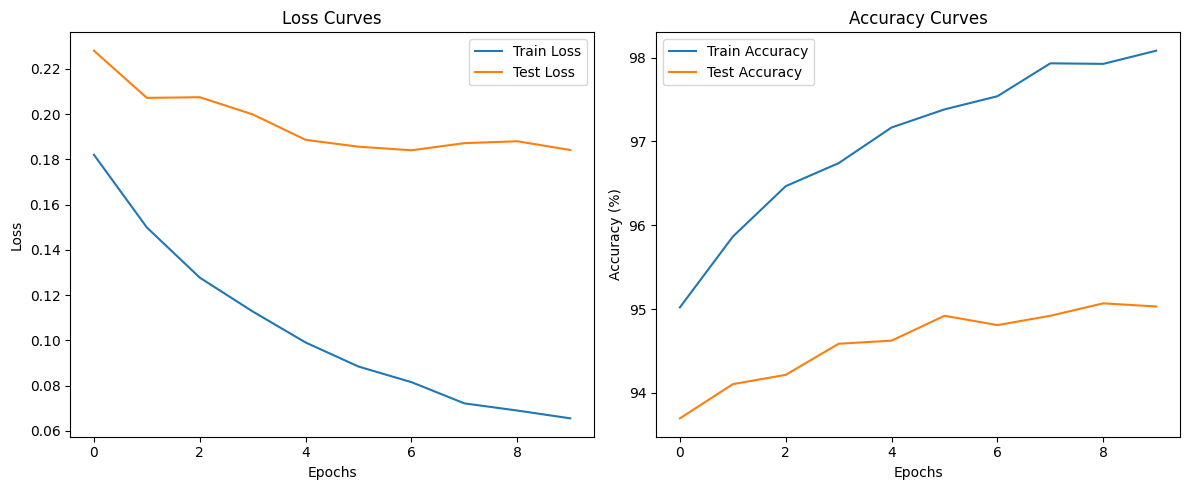

In [62]:
plt.figure(figsize=(12, 5))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves.png')
plt.show()

In [68]:
# Final evaluation
print("\nFinal Test Results:")
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")


Final Test Results:
Test Accuracy: 0.9503


In [69]:
# Print classification report
print("\nClassification Report:")
target_names = [idx_to_category[i] for i in range(len(unique_categories))]
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))


Classification Report:
                precision    recall  f1-score   support

   application     0.9722    0.9563    0.9642       183
         block     1.0000    0.9733    0.9865        75
         curve     0.9437    0.9384    0.9410       357
     dimension     0.9744    0.9744    0.9744       117
      document     0.9667    0.9667    0.9667        90
      geometry     0.9798    0.9238    0.9510       105
         grips     1.0000    0.9556    0.9773        45
         group     1.0000    0.9216    0.9592        51
         hatch     1.0000    1.0000    1.0000        48
         layer     0.9700    0.9510    0.9604       102
         light     1.0000    0.9722    0.9859        72
          line     0.9355    0.9667    0.9508        30
      linetype     1.0000    1.0000    1.0000        12
      material     0.9592    0.9792    0.9691        48
          mesh     0.9338    0.9407    0.9373       135
        object     0.9396    0.9500    0.9448       180
         plane     0.88


Classification Report:
                precision    recall  f1-score   support

   application       0.97      0.96      0.96       183
         block       1.00      0.97      0.99        75
         curve       0.94      0.94      0.94       357
     dimension       0.97      0.97      0.97       117
      document       0.97      0.97      0.97        90
      geometry       0.98      0.92      0.95       105
         grips       1.00      0.96      0.98        45
         group       1.00      0.92      0.96        51
         hatch       1.00      1.00      1.00        48
         layer       0.97      0.95      0.96       102
         light       1.00      0.97      0.99        72
          line       0.94      0.97      0.95        30
      linetype       1.00      1.00      1.00        12
      material       0.96      0.98      0.97        48
          mesh       0.93      0.94      0.94       135
        object       0.94      0.95      0.94       180
         plane       0.

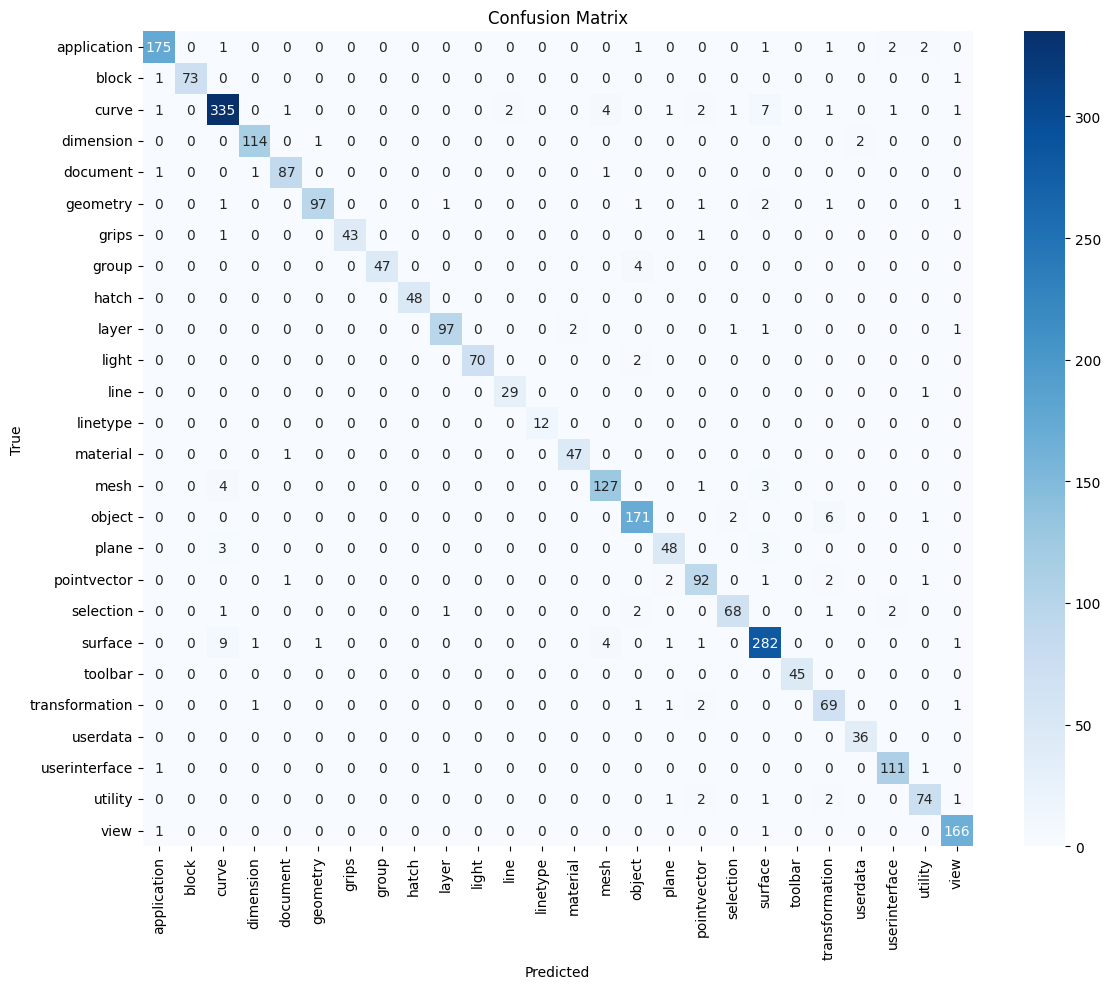

In [70]:
# Add after your training loop
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Convert indices to category names
pred_categories = [idx_to_category[idx] for idx in all_preds]
true_categories = [idx_to_category[idx] for idx in all_labels]

# Create and plot confusion matrix
cm = confusion_matrix(true_categories, pred_categories)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=unique_categories,
           yticklabels=unique_categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# Print classification report
report = classification_report(true_categories, pred_categories)
print("\nClassification Report:")
print(report)

In [73]:
# Add a confidence threshold for predictions
CONFIDENCE_THRESHOLD = 0.95

In [74]:
# Example of using the model for prediction with out-of-domain detection
def predict_category_with_rejection(query, model, word_to_idx, idx_to_category, max_length, confidence_threshold=CONFIDENCE_THRESHOLD):
    # Detect Rhino-related queries using keywords
    rhino_keywords = ['rhino', 'rhinoceros', 'grasshopper', 'nurbs', 'brep', 'mesh', 'surface',
                      'curve', 'point', 'object', 'layer', 'block', 'view', 'command', 'light',
                      'material', 'dimension', 'layout', 'geometry', 'transform', 'model']

    # Check if query is likely related to Rhino
    query_lower = query.lower()
    is_rhino_related = any(keyword in query_lower for keyword in rhino_keywords)

    # Preprocess
    tokens = preprocess_text(query)

    # Check token overlap with training vocabulary
    known_tokens = sum(1 for token in tokens if token in word_to_idx and token != "<UNK>")
    token_ratio = known_tokens / len(tokens) if tokens else 0

    # Convert to indices with handling for unknown tokens
    indices = []
    for token in tokens:
        if token in word_to_idx:
            indices.append(word_to_idx[token])
        else:
            indices.append(word_to_idx["<UNK>"])

    # Pad or truncate
    if len(indices) < max_length:
        indices.extend([word_to_idx["<PAD>"]] * (max_length - len(indices)))
    elif len(indices) > max_length:
        indices = indices[:max_length]

    # Convert to tensor and add batch dimension
    indices_tensor = torch.tensor([indices], dtype=torch.long).to(device)

    # Set model to eval mode
    model.eval()

    # Get prediction
    with torch.no_grad():
        outputs = model(indices_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        max_prob, predicted = torch.max(probs, dim=1)

    # Convert to category name
    category = idx_to_category[predicted.item()]
    confidence = max_prob.item()

    # Apply rejection strategy
    if (not is_rhino_related and token_ratio < 0.5) or confidence < confidence_threshold:
        return "not_rhino_related", confidence

    return category, confidence

In [75]:
# Try some sample queries including non-Rhino related ones
print("\nSample Predictions with Confidence:")
sample_queries = [
    "how do I list all files in a directory",  # Potentially ambiguous - could be OS command
    "show me how much memory is free",  # Non-Rhino
    "check if a website is up",  # Non-Rhino
    "how can I create a lofted surface in Rhino",  # Rhino-related
    "what is the command to create a mesh in Rhino",  # Rhino-related
    "I want to order pizza for dinner",  # Non-Rhino
    "can you help me create a NURBS curve",  # Rhino-related
    "what's the weather like today",  # Non-Rhino
    "who won the last world cup",  # Non-Rhino
    "how do I extrude a surface along a path in Rhino"  # Rhino-related
]

for query in sample_queries:
    category, confidence = predict_category_with_rejection(query, model, word_to_idx, idx_to_category, max_length)
    if category == "not_rhino_related":
        print(f"Query: '{query}' → Not Rhino related (Confidence: {confidence:.4f})")
    else:
        print(f"Query: '{query}' → Category: '{category}' (Confidence: {confidence:.4f})")


Sample Predictions with Confidence:
Query: 'how do I list all files in a directory' → Not Rhino related (Confidence: 0.8728)
Query: 'show me how much memory is free' → Not Rhino related (Confidence: 0.3331)
Query: 'check if a website is up' → Not Rhino related (Confidence: 0.3200)
Query: 'how can I create a lofted surface in Rhino' → Category: 'surface' (Confidence: 1.0000)
Query: 'what is the command to create a mesh in Rhino' → Category: 'mesh' (Confidence: 0.9998)
Query: 'I want to order pizza for dinner' → Not Rhino related (Confidence: 0.4941)
Query: 'can you help me create a NURBS curve' → Category: 'curve' (Confidence: 0.9971)
Query: 'what's the weather like today' → Not Rhino related (Confidence: 0.6089)
Query: 'who won the last world cup' → Not Rhino related (Confidence: 0.7530)
Query: 'how do I extrude a surface along a path in Rhino' → Category: 'surface' (Confidence: 1.0000)
